# Analyzing environmental impacts of urban expansion in Phoeniz, Arizona (2017-2020)
Author: Kat Le


## About


## Highlights


## Data
2020 Tiger/Line shapefiles: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from shapely.geometry import box
import contextily as ctx
from geogif import gif
import pystac_client
import stackstac

from pystac_client import Client # To access STAC catalogues

import planetary_computer # To sign items from MPC STAC Catalogue

from IPython.display import Image

### Preliminary exploration of Phoenix county spatial data


In [2]:
phoenix = gpd.read_file("data/phoenix.shp")

In [3]:
phoenix = phoenix.to_crs(epsg=3857)

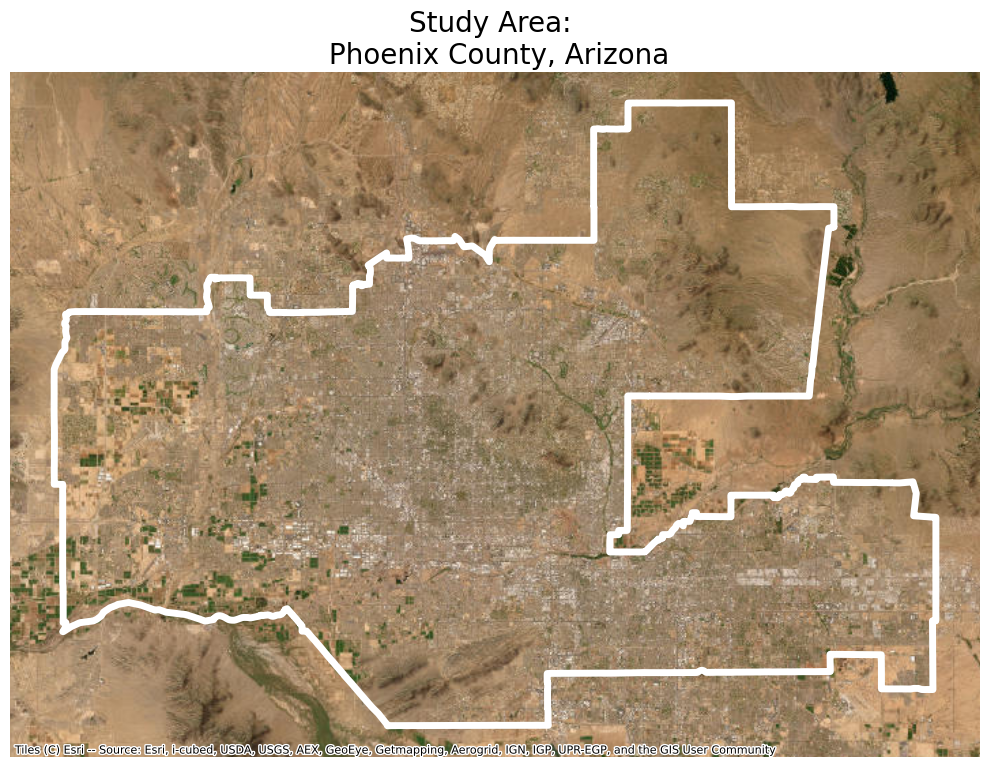

In [4]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Turn off axis
ax.set_axis_off()

# Plot the Phoenix data
phoenix.plot(ax=ax, facecolor='none', edgecolor='white', 
             alpha=1, linewidth=5, zorder=2)

# Add a basemap from contextily 
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# Add title
ax.set_title("Study Area: \n Phoenix County, Arizona", size = 20)

# Show plot
plt.tight_layout()
plt.show()

### Access Biodiverstiy Intactness Index
We use the `Client` function from the `pystac_client` package to access the catalog:

In [5]:
# Access MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [6]:
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_of_interest,
                        datetime=time_range)

# Retrieve items
items = search.item_collection()
len(items)


4

In [7]:
stack = (
    stackstac.stack(items, bounds_latlon=bbox_of_interest, assets=["data"])
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items]).year
        .to_numpy()
    )
    .sortby("time")
)
stack.name = "Biodiversity Intactness"
stack

<xarray.DataArray 'Biodiversity Intactness' (time: 4, band: 1, y: 991, x: 1830)> Size: 58MB
dask.array<getitem, shape=(4, 1, 991, 1830), dtype=float64, chunksize=(1, 1, 991, 1024), chunktype=numpy.ndarray>
Coordinates: (12/15)
    id              (time) <U50 800B 'bii_2017_34.74464974521749_-115.3859782...
  * band            (band) <U4 16B 'data'
  * x               (x) float64 15kB -112.8 -112.8 -112.8 ... -111.2 -111.2
  * y               (y) float64 8kB 33.86 33.86 33.86 ... 32.98 32.98 32.97
    end_datetime    (time) <U20 320B '2017-12-31T23:59:59Z' ... '2020-12-31T2...
    proj:epsg       int64 8B 4326
    ...              ...
    version         <U2 8B 'v1'
    title           <U23 92B 'Biodiversity Intactness'
    raster:bands    object 8B {'sampling': 'area', 'data_type': 'float32', 's...
    description     <U54 216B 'Terrestrial biodiversity intactness at 100m re...
    epsg            int64 8B 4326
  * time            (time) int32 16B 2017 2018 2019 2020
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-112.82750137012779, 32.973560...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-112.83|\n| 0.00,-0.00, 33.86|\n| 0.00, 0.00, 1...
    resolution:  0.0008983152841195215

In [8]:
bii = stack.squeeze().compute()

In [9]:
bii['time']

<xarray.DataArray 'time' (time: 4)> Size: 16B
array([2017, 2018, 2019, 2020], dtype=int32)
Coordinates: (12/13)
    id              (time) <U50 800B 'bii_2017_34.74464974521749_-115.3859782...
    band            <U4 16B 'data'
    end_datetime    (time) <U20 320B '2017-12-31T23:59:59Z' ... '2020-12-31T2...
    proj:epsg       int64 8B 4326
    proj:shape      object 8B {7992}
    proj:transform  object 8B {0.0, 1.0, 34.74464974521749, 0.000898315284119...
    ...              ...
    version         <U2 8B 'v1'
    title           <U23 92B 'Biodiversity Intactness'
    raster:bands    object 8B {'sampling': 'area', 'data_type': 'float32', 's...
    description     <U54 216B 'Terrestrial biodiversity intactness at 100m re...
    epsg            int64 8B 4326
  * time            (time) int32 16B 2017 2018 2019 2020

In [10]:
# match crs to bii
phoenix = phoenix.to_crs(bii.rio.crs)

In [11]:
assert bii.rio.crs == phoenix.crs

In [38]:
bii_2017 = bii.sel(time=2017)

bii_2017 = bii_2017.rio.clip(phoenix.geometry)

above75_2017 = (bii_2017 >= 0.75).sum().item()
total_cells = bii_2017.shape[0]*bii_2017.shape[1]

print(f"BII 2017 - Percent area above 75: {round((above75_2017 / total_cells)*100, 2)}%")

BII 2017 - Percent area above 75: 4.17%


In [39]:
bii_2020 = bii.sel(time=2020)

bii_2020 = bii_2020.rio.clip(phoenix.geometry)

above75_2020 = (bii_2020 >= 0.75).sum().item()
total_cells = bii_2020.shape[0]*bii_2020.shape[1]

print(f"BII 2020 - Percent area above 75: {round((above75_2020 / total_cells)*100, 2)}%")

BII 2020 - Percent area above 75: 3.8%
